In [59]:
import pandas as pd
import numpy as np
import re
from sklearn.utils import shuffle
from sklearn.model_selection    import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model       import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics            import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import learning_curve
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.base import TransformerMixin, BaseEstimator
from scipy import sparse
from scipy.sparse import hstack, csr_matrix

In [49]:
class KeywordIndicator(TransformerMixin, BaseEstimator):
    """
    Outputs a binary feature for each keyword indicating presence in the text.
    """
    def __init__(self, keywords):
        self.keywords = list(keywords)
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        mat = np.zeros((len(X), len(self.keywords)), dtype=int)
        for i, doc in enumerate(X):
            doc_l = doc.lower()
            for j, kw in enumerate(self.keywords):
                if kw in doc_l:
                    mat[i, j] = 1
        return sparse.csr_matrix(mat)
SPAM_KW = {"free","congratulations","urgent","click","offer","win","prize"}
HAM_KW  = {"meeting","team","project","lunch","coffee","call"}
ALL_KW  = SPAM_KW | HAM_KW
ALL_KW

{'call',
 'click',
 'coffee',
 'congratulations',
 'free',
 'lunch',
 'meeting',
 'offer',
 'prize',
 'project',
 'team',
 'urgent',
 'win'}


## Load and Combine Datasets


In [21]:
# Load both CSVs
orig_df = pd.read_csv("spam_and_ham_classification.csv")   
ext_df  = pd.read_csv("combined_data.csv")        

# Standardize column names
if "message" in ext_df.columns and "text" not in ext_df.columns:
    ext_df.rename(columns={"message": "text"}, inplace=True)

# Convert numeric labels in ext_df (0→ham, 1→spam)
if pd.api.types.is_numeric_dtype(ext_df["label"]):
    ext_df["label"] = ext_df["label"].map({0:"ham", 1:"spam"})

# Ensure orig_df labels are lowercase strings
orig_df["label"] = orig_df["label"].astype(str).str.lower()

# Drop any rows missing text or label, and keep only ‘ham’/‘spam’
for df_ in (orig_df, ext_df):
    df_.dropna(subset=["text","label"], inplace=True)
    df_[:] = df_[df_["label"].isin(["ham","spam"])]

# Concatenate and shuffle
df = pd.concat([orig_df, ext_df], ignore_index=True)
df = shuffle(df, random_state=42).reset_index(drop=True)

# Check
print("Combined dataset shape:", df.shape)
print("Label distribution:\n", df["label"].value_counts())
df.head()

Combined dataset shape: (93437, 2)
Label distribution:
 label
spam    48605
ham     44832
Name: count, dtype: int64


,label,text
0,ham,fyi . . . i believe we are doing the right thi...
1,ham,its installation and configuration tasks are ...
2,ham,bull market report sumbescapenumberl hxpncurre...
3,spam,test :\nun fin de semana gratis\nsi usted dese...
4,spam,be proud of the bulge inside your pants with v...


In [22]:
# Ensure every label is exactly 'ham' or 'spam' 
df["label"] = df["label"].astype(str).str.lower()

# Drop any rows with invalid or missing labels
valid = df["label"].isin(["ham", "spam"])
print(f"Dropping {len(df) - valid.sum()} rows with invalid labels")
df = df[valid].reset_index(drop=True)

# check
print("Remaining shape:", df.shape)
print(df["label"].value_counts())


Dropping 0 rows with invalid labels
Remaining shape: (93437, 2)
label
spam    48605
ham     44832
Name: count, dtype: int64


## Text Cleaning

In [24]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    return re.sub(r"\s+", " ", text).strip()

df["clean_text"] = df["text"].astype(str).apply(clean_text)
df["exclams"]    = df["clean_text"].str.count("!")
df["url_count"]  = df["text"].str.contains(r"http\S+").astype(int)
df["perc_alpha"] = df["text"].apply(lambda s: sum(c.isalpha() for c in s)/len(s))


# Preview
df[["clean_text","label"]].head()


,clean_text,label
0,fyi i believe we are doing the right things jr...,ham
1,its installation and configuration tasks are p...,ham
2,bull market report sumbescapenumberl hxpncurre...,ham
3,test un fin de semana gratis si usted desea pa...,spam
4,be proud of the bulge inside your pants with v...,spam


In [25]:
# Drop Duplicates
df = df.drop_duplicates(subset="clean_text")

#Eliminate Noise
def is_noisy(text, alpha_thresh=0.5):
    """Return True if <alpha_thresh> fraction of chars are alphabetic."""
    alpha = sum(c.isalpha() for c in text)
    return (alpha / max(1, len(text))) < alpha_thresh

# Remove all rows where >50% of chars are non-alphabetic
keep = ~df["text"].apply(is_noisy)
print(f"Dropping {len(df) - keep.sum()} noisy examples")
df = df[keep].reset_index(drop=True)
df[["clean_text","label"]].head(-1)



Dropping 1074 noisy examples


,clean_text,label
0,fyi i believe we are doing the right things jr...,ham
1,its installation and configuration tasks are p...,ham
2,bull market report sumbescapenumberl hxpncurre...,ham
3,test un fin de semana gratis si usted desea pa...,spam
4,be proud of the bulge inside your pants with v...,spam
...,...,...
81803,we help you get m e d s for cheap 9 zv 25 slb ...,spam
81804,ivo i don t know whether you ever got a proper...,ham
81805,escapelong escapelong escapelong escapelong es...,spam
81806,correct everyone is on board with this gp orig...,ham


## Train / Validation / Test Split (80/10/10 stratified)


In [27]:
# Perform a stratified split to preserve class balance
train_df, temp_df = train_test_split(
    df,
    test_size=0.20,
    stratify=df["label"],
    random_state=42
)

# Split the remaining 20% into 10% validation and 10% test
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    stratify=temp_df["label"],
    random_state=42
)

# Verify shapes and class distributions
for name, subset in [("Train", train_df), ("Val", val_df), ("Test", test_df)]:
    print(f"{name} set: {subset.shape}")
    print(subset["label"].value_counts(normalize=True), "\n")


Train set: (65447, 6)
label
spam    0.526151
ham     0.473849
Name: proportion, dtype: float64 

Val set: (8181, 6)
label
spam    0.526219
ham     0.473781
Name: proportion, dtype: float64 

Test set: (8181, 6)
label
spam    0.526097
ham     0.473903
Name: proportion, dtype: float64 



In [28]:
train_df = train_df.reset_index(drop=True)
val_df   = val_df.reset_index(drop=True)
test_df  = test_df.reset_index(drop=True)

print("Shapes after reset:", train_df.shape, val_df.shape, test_df.shape)

Shapes after reset: (65447, 6) (8181, 6) (8181, 6)


In [29]:
SPAM_KW = {"free","congratulations","urgent","click","offer","win","prize"}
HAM_KW  = {"meeting","team","project","lunch","coffee","call"}
ALL_KW  = SPAM_KW | HAM_KW

# Fit/transform on each split
kw_ind = KeywordIndicator(ALL_KW)
kw_ind.fit(train_df["clean_text"])  

KeywordIndicator(keywords=['win', 'meeting', 'congratulations', 'call',
                           'project', 'team', 'urgent', 'lunch', 'click',
                           'offer', 'prize', 'free', 'coffee'])

## TF-IDF Vectorization

In [31]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(min_df=2, max_df=0.9, ngram_range=(1,2))

# Fit on the training set, then transform all three
X_train = vectorizer.fit_transform(train_df["clean_text"])
X_val   = vectorizer.transform(val_df["clean_text"])
X_test  = vectorizer.transform(test_df["clean_text"])

# Encode labels as binary (ham=0, spam=1)
y_train = train_df["label"].map({"ham": 0, "spam": 1}).values
y_val   = val_df["label"].map({"ham": 0, "spam": 1}).values
y_test  = test_df["label"].map({"ham": 0, "spam": 1}).values

# Print shapes to confirm
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val   shape:", X_val.shape)
print("y_val   shape:", y_val.shape)
print("X_test  shape:", X_test.shape)
print("y_test  shape:", y_test.shape)

X_train shape: (65447, 1111768)
y_train shape: (65447,)
X_val   shape: (8181, 1111768)
y_val   shape: (8181,)
X_test  shape: (8181, 1111768)
y_test  shape: (8181,)


In [32]:
from sklearn.base import TransformerMixin, BaseEstimator
# Define KeywordIndicator
class KeywordIndicator(TransformerMixin, BaseEstimator):
    def __init__(self, keywords):
        self.keywords = list(keywords)
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        M, N = len(X), len(self.keywords)
        mat = np.zeros((M, N), dtype=int)
        for i, doc in enumerate(X):
            d = doc.lower()
            for j, kw in enumerate(self.keywords):
                if kw in d:
                    mat[i, j] = 1
        return csr_matrix(mat)

# Your keyword sets
SPAM_KW = {"free","congratulations","urgent","click","offer","win","prize"}
HAM_KW  = {"meeting","team","project","lunch","coffee","call"}
ALL_KW  = SPAM_KW | HAM_KW

# Transform on each split
kw_ind = KeywordIndicator(ALL_KW)
_ = kw_ind.fit(train_df["clean_text"])

K_train = kw_ind.transform(train_df["clean_text"])
K_val   = kw_ind.transform(val_df["clean_text"])
K_test  = kw_ind.transform(test_df["clean_text"])

# Stack with TF–IDF
X_train = hstack([X_train, K_train])
X_val   = hstack([X_val,   K_val])
X_test  = hstack([X_test,  K_test])

# Confirm shapes
print("Augmented feature shapes:")
print(" X_train:", X_train.shape)
print(" X_val:  ", X_val.shape)
print(" X_test: ", X_test.shape)

Augmented feature shapes:
 X_train: (65447, 1111781)
 X_val:   (8181, 1111781)
 X_test:  (8181, 1111781)


## Baseline Model: Logistic Regression

In [34]:
# Initialize and train Logistic Regression
lr = LogisticRegression(max_iter=10000, random_state=13)
lr.fit(X_train, y_train)

# Predict on validation set
y_val_pred_lr = lr.predict(X_val)

# Compute metrics
acc_lr = accuracy_score(y_val, y_val_pred_lr)
prec_lr, rec_lr, f1_lr, _ = precision_recall_fscore_support(
    y_val, y_val_pred_lr, average="binary", pos_label=1
)

# Print results
print("Logistic Regression Validation Metrics:")
print(f"  Accuracy : {acc_lr:.4f}")
print(f"  Precision: {prec_lr:.4f}")
print(f"  Recall   : {rec_lr:.4f}")
print(f"  F1-score : {f1_lr:.4f}")

Logistic Regression Validation Metrics:
  Accuracy : 0.9172
  Precision: 0.9123
  Recall   : 0.9324
  F1-score : 0.9222


 ## Confusion Matrix Visualization 

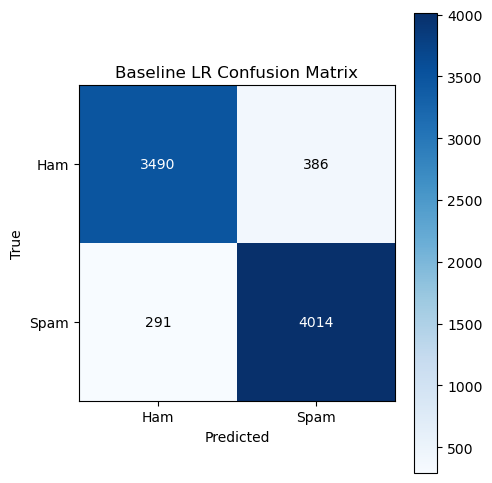

In [36]:
cm = confusion_matrix(y_val, y_val_pred_lr)

fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(cm, cmap="Blues")
ax.set_title("Baseline LR Confusion Matrix")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_xticks([0,1]); ax.set_yticks([0,1])
ax.set_xticklabels(["Ham","Spam"]); ax.set_yticklabels(["Ham","Spam"])

thresh = cm.max() / 2
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], 
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()



## Hyperparameter Tuning (Linear SVM)


In [38]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from tqdm.notebook import tqdm

# Values of C to try
param_values = [0.01, 0.1, 1, 10, 100]

best_C, best_score = None, 0
results = {}

# Loop with tqdm progress bar
for C in tqdm(param_values, desc="Tuning C values"):
    svc = LinearSVC(C=C, random_state=13, max_iter=10000, dual=False)
    cv_scores = cross_val_score(
        svc, X_train, y_train,
        cv=5, scoring='f1', n_jobs=-1
    )
    mean_score = cv_scores.mean()
    results[C] = mean_score
    if mean_score > best_score:
        best_score, best_C = mean_score, C

print(f"\nBest C: {best_C} with CV F1 = {best_score:.4f}")

# Train the final tuned model
tuned_svm = LinearSVC(
    C=best_C, random_state=13, max_iter=10000, dual=False
)
tuned_svm.fit(X_train, y_train)


Tuning C values:   0%|          | 0/5 [00:00<?, ?it/s]


Best C: 0.1 with CV F1 = 0.9309


LinearSVC(C=0.1, dual=False, max_iter=10000, random_state=13)

## Validation-Set Evaluation of Tuned SVM

Validation Results (C=0.1):
  Accuracy : 0.9193
  Precision: 0.9143
  Recall   : 0.9343
  F1-score : 0.9242


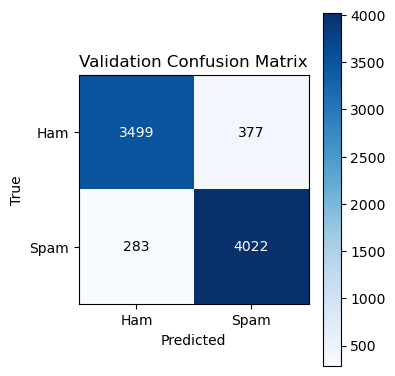

In [40]:
# Predict on validation data
y_val_pred_tuned = tuned_svm.predict(X_val)

# Compute metrics
acc_v, prec_v, rec_v, f1_v = (
    accuracy_score(y_val, y_val_pred_tuned),
    *precision_recall_fscore_support(y_val, y_val_pred_tuned, average='binary', pos_label=1)[:3]
)
print(f"Validation Results (C={tuned_svm.C}):")
print(f"  Accuracy : {acc_v:.4f}")
print(f"  Precision: {prec_v:.4f}")
print(f"  Recall   : {rec_v:.4f}")
print(f"  F1-score : {f1_v:.4f}")

# Plot confusion matrix
cm_v = confusion_matrix(y_val, y_val_pred_tuned)
fig, ax = plt.subplots(figsize=(4,4))
im = ax.imshow(cm_v, cmap='Blues')
ax.set_title('Validation Confusion Matrix')
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_xticks([0,1])
ax.set_yticks([0,1])
ax.set_xticklabels(['Ham','Spam'])
ax.set_yticklabels(['Ham','Spam'])
thresh = cm_v.max()/2
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm_v[i,j],
                ha='center', va='center',
                color='white' if cm_v[i,j]>thresh else 'black')
plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()


##  Final Test-Set Evaluation

Test Results:
  Accuracy : 0.9286
  Precision: 0.9237
  Recall   : 0.9421
  F1-score : 0.9328


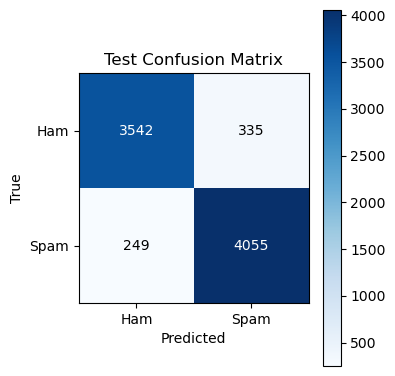

In [42]:
# Predict on test data
y_test_pred = tuned_svm.predict(X_test)

# Compute final metrics
acc_t, prec_t, rec_t, f1_t = (
    accuracy_score(y_test, y_test_pred),
    *precision_recall_fscore_support(
         y_test, y_test_pred, average='binary', pos_label=1
      )[:3]
)

print("Test Results:")
print(f"  Accuracy : {acc_t:.4f}")
print(f"  Precision: {prec_t:.4f}")
print(f"  Recall   : {rec_t:.4f}")
print(f"  F1-score : {f1_t:.4f}")

# 3. Plot test confusion matrix
cm_t = confusion_matrix(y_test, y_test_pred)
fig, ax = plt.subplots(figsize=(4,4))
im = ax.imshow(cm_t, cmap='Blues')
ax.set_title('Test Confusion Matrix')
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_xticks([0,1]); ax.set_yticks([0,1])
ax.set_xticklabels(['Ham','Spam'])
ax.set_yticklabels(['Ham','Spam'])
thresh = cm_t.max() / 2
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm_t[i, j],
                ha='center', va='center',
                color='white' if cm_t[i, j] > thresh else 'black')
plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()



### Ablation Study: TF–IDF Configurations

In [85]:


configs = [
    ("Unigram Only",       (1,1), 3, 0.85),
    ("Unigram + Bigram",   (1,2), 3, 0.85),
    ("Strict Filtering",   (1,2), 5, 0.80),
]

rows = []
for name, ngram_range, min_df, max_df in configs:
    vect = TfidfVectorizer(ngram_range=ngram_range,
                           min_df=min_df,
                           max_df=max_df)
    X_tr = vect.fit_transform(train_df["clean_text"])
    X_vl = vect.transform(val_df["clean_text"])
    svm = LinearSVC(C=tuned_svm.C, random_state=13, max_iter=10000)
    svm.fit(X_tr, y_train)
    preds = svm.predict(X_vl)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_val, preds, average="binary", pos_label=1
    )
    rows.append((name, prec, rec, f1))

ablation_df = pd.DataFrame(rows, columns=["Config","Precision","Recall","F1-score"])
ablation_df


,Config,Precision,Recall,F1-score
0,Unigram Only,0.912018,0.934262,0.923006
1,Unigram + Bigram,0.913981,0.935424,0.924578
2,Strict Filtering,0.914753,0.934727,0.924632


### Learning Curve: Tuned SVM Performance vs. Training Size


Full feature matrix shape: (65447, 1111781)


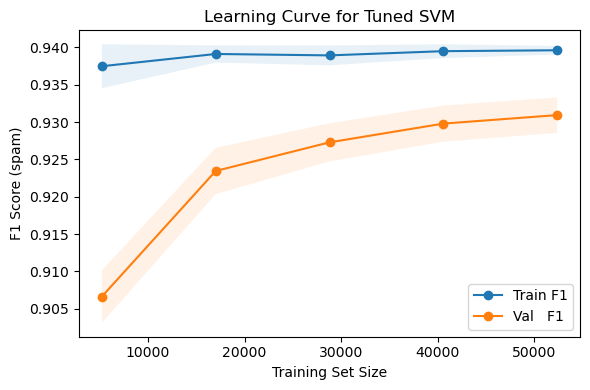

In [92]:
# Rebuild your full TF–IDF + Keyword features on train_df
X_tfidf_full = vectorizer.transform(train_df["clean_text"]) 
X_kw_full    = kw_ind.transform(train_df["clean_text"])     
X_full       = hstack([X_tfidf_full, X_kw_full])            
print("Full feature matrix shape:", X_full.shape)

# Define the estimator with your best C
svm_est = LinearSVC(C=best_C, random_state=13, max_iter=10000, dual=False)

# Compute learning curve on numeric matrix
train_sizes, train_scores, val_scores = learning_curve(
    estimator=svm_est,
    X=X_full,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 5),
    cv=5,
    scoring="f1",
    n_jobs=-1,
    shuffle=True,
    random_state=42
)

# Aggregate means and stds
train_mean = train_scores.mean(axis=1)
train_std  = train_scores.std(axis=1)
val_mean   = val_scores.mean(axis=1)
val_std    = val_scores.std(axis=1)

# Plotting
plt.figure(figsize=(6,4))
plt.plot(train_sizes, train_mean, 'o-', label="Train F1")
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.1)
plt.plot(train_sizes, val_mean, 'o-', label="Val   F1")
plt.fill_between(train_sizes, val_mean-val_std, val_mean+val_std, alpha=0.1)
plt.xlabel("Training Set Size")
plt.ylabel("F1 Score (spam)")
plt.title("Learning Curve for Tuned SVM")
plt.legend(loc="best")
plt.tight_layout()
plt.show()


### Error Analysis: Inspect Misclassifications

False Positives (ham→spam): 335
online application approval tue , 21 sep 2004 00 : 17 : 07 + 0300
you have been pre - approved for rates starting at 3 . 25 % fixed .
please use our secure site to fill - out your application .
thank you .
http : / / mgmhomeloan . net / ? partid = vn
to be taken off future : http : / / mgmhomeloan . net / st . html
usa lenders network
box 40937
bedford , nova scotia ,
canada , b 4 a 3 z 2
silky elena bach ma cannot cheerlead
blaspheme populate antiquated bedford stratosphere newsletter 

False Negatives (spam→ham): 249
on escapenumber escapenumber escapenumber mark j reed wrote my expectation before reading the delta was that negative counts would do a reversal escapenumber x escapenumber escapenumber 'a' 'b' 'c' xx escapenumber 'c' 'b' 'a' 'c' 'b' 'a' 'c' 'b' 'a' i don't know why i think that makes sense but it was honestly my first thought does it make sense to anyone else is there a compelling reason i'm missing for having negative values behave as if

,Error Type,Count,% of Test Set
0,False positives (ham→spam),335,4.09 %
1,False negatives (spam→ham),249,3.04 %


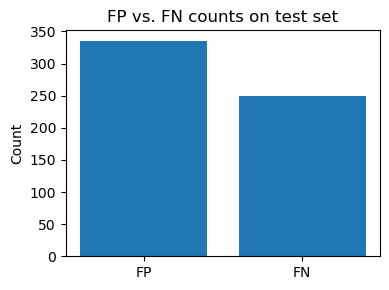

In [118]:
eval_df = test_df.copy()

# Predict on X_test
y_test_pred = tuned_svm.predict(X_test)

# Build a results DataFrame
results = pd.DataFrame({
    "text":       eval_df["text"].values,
    "true_label": eval_df["label"].values,
    "pred_label": ["spam" if p==1 else "ham" for p in y_test_pred]
})

# False Positives
fp = results[(results["true_label"]=="ham") & (results["pred_label"]=="spam")]
print(f"False Positives (ham→spam): {len(fp)}")
print("\n".join(fp["text"].head(1).tolist()), "\n")

# False Negatives
fn = results[(results["true_label"]=="spam") & (results["pred_label"]=="ham")]
print(f"False Negatives (spam→ham): {len(fn)}")
print("\n".join(fn["text"].head(1).tolist()))
cm = confusion_matrix(y_test, y_test_pred, labels=[0, 1])  # 0 = ham, 1 = spam
tn, fp, fn, tp = cm.ravel()

total_test  = len(y_test)
fp_rate_pct = 100 * fp / (fp + tn)
fn_rate_pct = 100 * fn / (fn + tp)

print("Confusion matrix (ham=0, spam=1):\n", cm, "\n")

err_tbl = pd.DataFrame(
    {
        "Error Type": ["False positives (ham→spam)", "False negatives (spam→ham)"],
        "Count": [fp, fn],
        "% of Test Set": [f"{100*fp/total_test:.2f} %", f"{100*fn/total_test:.2f} %"],
    }
)
display(err_tbl)

# Optional: quick bar plot
plt.figure(figsize=(4,3))
plt.bar(["FP", "FN"], [fp, fn])
plt.title("FP vs. FN counts on test set")
plt.ylabel("Count")
plt.tight_layout()
plt.show()



### Save Artifacts & Environment

In [96]:
import joblib, os, subprocess

# Ensure models/ folder exists
os.makedirs("models", exist_ok=True)

# Persist tuned SVM and TF-IDF vectorizer
joblib.dump(tuned_svm, "models/tuned_svm.joblib")
joblib.dump(vectorizer, "models/tfidf_vectorizer.joblib")

# Capture exact package versions
with open("requirements.txt", "w") as f:
    
    subprocess.run(["pip", "freeze"], stdout=f)

print("Models saved in models/ and requirements.txt generated.")


Models saved in models/ and requirements.txt generated.


### Inference Helper

In [101]:
# Reload artifacts
vectorizer = joblib.load("models/tfidf_vectorizer.joblib")
tuned_svm  = joblib.load("models/tuned_svm.joblib")

# Define keyword indicator (must match training exactly)
SPAM_KW = {"free","congratulations","urgent","click","offer","win","prize"}
HAM_KW  = {"meeting","team","project","lunch","coffee","call"}
ALL_KW  = list(SPAM_KW | HAM_KW)

class KeywordIndicator(TransformerMixin, BaseEstimator):
    def __init__(self, keywords):
        self.keywords = keywords
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        M, N = len(X), len(self.keywords)
        mat = np.zeros((M, N), dtype=int)
        for i, doc in enumerate(X):
            doc_l = doc.lower()
            for j, kw in enumerate(self.keywords):
                if kw in doc_l:
                    mat[i, j] = 1
        return csr_matrix(mat)

kw_ind = KeywordIndicator(ALL_KW)

# Cleaning function
def clean_text(text: str) -> str:
    text = text.lower()
    text = re.sub(r"http\S+","", text)
    text = re.sub(r"[^a-z0-9\s]"," ", text)
    return re.sub(r"\s+"," ", text).strip()

# Classifier that stacks features
def classify_messages(messages):
    cleaned = [clean_text(m) for m in messages]
    X_tfidf = vectorizer.transform(cleaned)
    X_kw    = kw_ind.transform(cleaned)
    X_full  = hstack([X_tfidf, X_kw])
    preds   = tuned_svm.predict(X_full)
    return ['spam' if p==1 else 'ham' for p in preds]

samples = [
    # ----- SPAM -----
    # 1. Promotional
    "FLASH SALE! Get 70% off all shoes TODAY only at www.deals.com",
    # 2. Phishing
    "Alert: Your bank account will be locked!  Click here to verify immediately: http://fakebank.verify-info.com",
    # 3. Scam
    "Congratulations – you’ve been selected for a $500 gift voucher. Reply “YES” to claim.",
    
    # ----- HAM -----
    # 4. Scheduling
    "Hi Sarah, are we still on for lunch at 12:30 PM tomorrow at our usual spot?",
    # 5. Family / Friendly
    "Hey Dad, just got home—let me know if you need anything from the store!",
    # 6. Personal payment (ham)
    "Hi Chris, I just sent you $50 for our concert tickets via Venmo—thanks for covering me! Let me know when you receive it."

]
print(classify_messages(samples))



['spam', 'spam', 'spam', 'ham', 'ham', 'ham']


### Sanity Check


In [105]:
# Verify that artifacts are loaded and ready
assert 'tuned_svm' in globals() and 'vectorizer' in globals()
print(" Sanity check passed: tuned_svm and vectorizer are in memory.")


 Sanity check passed: tuned_svm and vectorizer are in memory.
